In [4]:
!pip install sqlalchemy pandas psycopg2-binary matplotlib seaborn tensorflow setuptools scikit-learn pydot==1.4.2

In [2]:
%load_ext tensorboard

In [42]:
import warnings
warnings.filterwarnings('ignore')

# Import
You first have to import the data from `ds/dump.sql`. To do so run `docker compose up -d` and `data/scripts/import.sh`.
This will import the data from the database dump. Originally the data was stored in a GCP cloud SQL instance and the dump was exported with the script `data/scripts/export.sh`

In [1]:
import matplotlib.pyplot as plt
import datetime
import random
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from tensorflow import keras
from keras import backend as K


url = URL.create(
    drivername="postgresql",
    username="postgres",
    password="password",
    host="localhost",
    database="data",
)
db = create_engine(url)
conn = db.connect()

data = pd.read_sql_query("""
                         SELECT 
                         P.resort, P.date, 
                         MAX(P.price) as max_price, 
                         AVG(P.price) as avg_price, 
                         MIN(P.price) as min_price,
                         MAX(W.apparent_temperature) as max_apparent_temperature,
                         AVG(W.apparent_temperature) as avg_apparent_temperature,
                         MIN(W.apparent_temperature) as min_apparent_temperature,
                         MAX(W.precipitation) as max_precipitation,
                         AVG(W.precipitation) as avg_precipitation,
                         MIN(W.precipitation) as min_precipitation,
                         MAX(W.temperature_2m) as max_temp,
                         AVG(W.temperature_2m) as avg_temp,
                         MIN(W.temperature_2m) as min_temp,
                         MAX(W.wind_speed_100m) as max_wind,
                         AVG(W.wind_speed_100m) as avg_wind,
                         MIN(W.wind_speed_100m) as min_wind,
                         MAX(W.rain) as max_rain,
                         MIN(W.rain) as min_rain,
                         AVG(W.rain) as avg_rain,
                         MAX(W.snow_depth) as max_snow_depth,
                         MAX(W.cloud_cover) as max_cloud_cover,
                         SUM(W.snowfall) as sum_snow,
                         SUM(W.sunshine_duration) as sum_sunshine
                         FROM prices as P
                         INNER JOIN weather as W 
                         ON Date(W.date) = Date(P.date)
                         AND W.resort = P.resort
                         GROUP BY P.resort, P.date
                         """, conn)
data.index = pd.to_datetime(data["date"]).apply(lambda x: x.date())

# Feature enginnering
data["weekday"] = pd.to_datetime(data["date"]).apply(lambda x: x.date().weekday())
data["weekend"] = pd.to_datetime(data["date"]).apply(lambda x: 1 if x.date().weekday() > 4 else 0)
data.describe()

2024-05-10 13:49:54.007714: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 13:49:54.008219: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 13:49:54.011885: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 13:49:54.074290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 13:49:55.179204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

max_price   avg_price   min_price  max_apparent_temperature  \
count  197.000000  197.000000  197.000000                197.000000   
mean    69.345178   64.368646   61.631980                 -0.633015   
std     10.250567    8.288984    7.340678                  6.609045   
min     55.000000   51.188216   49.000000                -12.862125   
25%     64.000000   58.394248   55.000000                 -4.816090   
50%     67.000000   64.000000   64.000000                 -2.410789   
75%     74.000000   68.236061   67.000000                  2.164895   
max     94.500000   90.430836   83.500000                 22.771229   

       avg_apparent_temperature  min_apparent_temperature  max_precipitation  \
count                197.000000                197.000000         197.000000   
mean                  -5.410601                -10.957961           0.984264   
std                    5.606393                  5.874564           1.245361   
min                  -17.148169                -25.281313           0.000000   
25%                   -9.251680                -15.092754           0.000000   
50%                   -6.586293                -11.365122           0.400000   
75%                   -2.143950                 -6.616779           1.700000   
max                   12.119329                  1.769660           6.000000   

       avg_precipitation  min_precipitation    max_temp  ...    min_wind  \
count         197.000000         197.000000  197.000000  ...  197.000000   
mean            0.212225           0.000508    2.384901  ...    5.096181   
std             0.302477           0.007125    5.862051  ...    5.096970   
min             0.000000           0.000000   -8.233500  ...    0.360000   
25%             0.000000           0.000000   -1.333500  ...    1.484318   
50%             0.070833           0.000000    0.925000  ...    3.075841   
75%             0.333333           0.000000    4.561000  ...    7.208994   
max             2.037500           0.100000   22.530500  ...   27.852928   

         max_rain  min_rain    avg_rain  max_snow_depth  max_cloud_cover  \
count  197.000000     197.0  197.000000      193.000000       197.000000   
mean     0.166497       0.0    0.031113        2.014301        96.408630   
std      0.431058       0.0    0.089037        0.366185        11.961595   
min      0.000000       0.0    0.000000        1.360000        30.000002   
25%      0.000000       0.0    0.000000        1.690000       100.000000   
50%      0.000000       0.0    0.000000        2.060000       100.000000   
75%      0.100000       0.0    0.008333        2.260000       100.000000   
max      3.200000       0.0    0.579167        2.810000       100.000000   

           sum_snow  sum_sunshine     weekday     weekend  
count    197.000000  1.970000e+02  197.000000  197.000000  
mean    5866.631017  5.449657e+07    3.060914    0.299492  
std    10869.360097  5.444639e+07    2.004165    0.459203  
min        0.000000  0.000000e+00    0.000000    0.000000  
25%        0.000000  1.026440e+07    1.000000    0.000000  
50%      755.580000  4.102183e+07    3.000000    0.000000  
75%     6957.300166  8.228880e+07    5.000000    1.000000  
max    76383.718110  2.654008e+08    6.000000    1.000000  

[8 rows x 24 columns]

In [4]:
groups = data.groupby("resort")
for a in groups:
    print(a[0], a[1].shape)

adelboden (35, 26)
gstaad (38, 26)
laax (39, 26)
pizol (41, 26)
scuol (44, 26)


In [5]:
def get_mondays(start, end):
    start = start - datetime.timedelta(days=start.weekday())
    end = end - datetime.timedelta(days=end.weekday())
    current = start
    while current <= end:
        yield current
        current = current + datetime.timedelta(days=7)

def print_groups(groups, cols):
    fig = plt.figure(figsize=(40, 20))
    for index, (group_name, df) in enumerate(groups):
        axis = fig.add_subplot(
            5,1,index+1,
            yticks=[],
            title=group_name
        )
        #df = df[df.index >= datetime.datetime.strptime("2024-02-19", '%Y-%m-%d').date()]
        
        for monday in get_mondays(df.index.min(), df.index.max()):
            axis.vlines(monday, 0, 1, color='black', linestyle='--')
            axis.text(monday,0, monday.strftime('%a %Y-%m-%d') ,rotation=90)

        for index, (col, color, pltarea) in enumerate(cols):
            ax = axis.twinx()
            if index > 0:
                ax.plot(df.index, df[col], color=color)
                if len(pltarea):
                    ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
                ax.set_yticks([])
                sax = ax.secondary_yaxis(1.0 + 0.02 * (index - 1))
                sax.set_ylabel(col, color=color)
                sax.tick_params(axis='y', labelcolor=color)
            else:
                ax.scatter(df.index, df[col], color=color, marker='x')
                if len(pltarea):
                    ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
                ax.yaxis.set_ticks_position("left")
                ax.yaxis.set_label_position("left")
                ax.set_ylabel(col, color=color)
                ax.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    return fig

def print_violins(groups, drop_cols=[]):
    fig = plt.figure(figsize=(20, 35)) 
    for index, (group_name, df) in enumerate(groups):
        df = df.drop(columns=drop_cols)
        df_mean = df.mean()
        df_std = df.std()
        df_std = (df - df_mean) / df_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        axis = fig.add_subplot(
            2*len(groups.groups),1,index+1,
            title=f"{group_name} - Features"
        )
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std, ax=axis)
        ax.tick_params(axis='x', labelrotation=45)
    fig.tight_layout()
    return fig

def flatten(matrix):
    return [item for row in matrix for item in row]

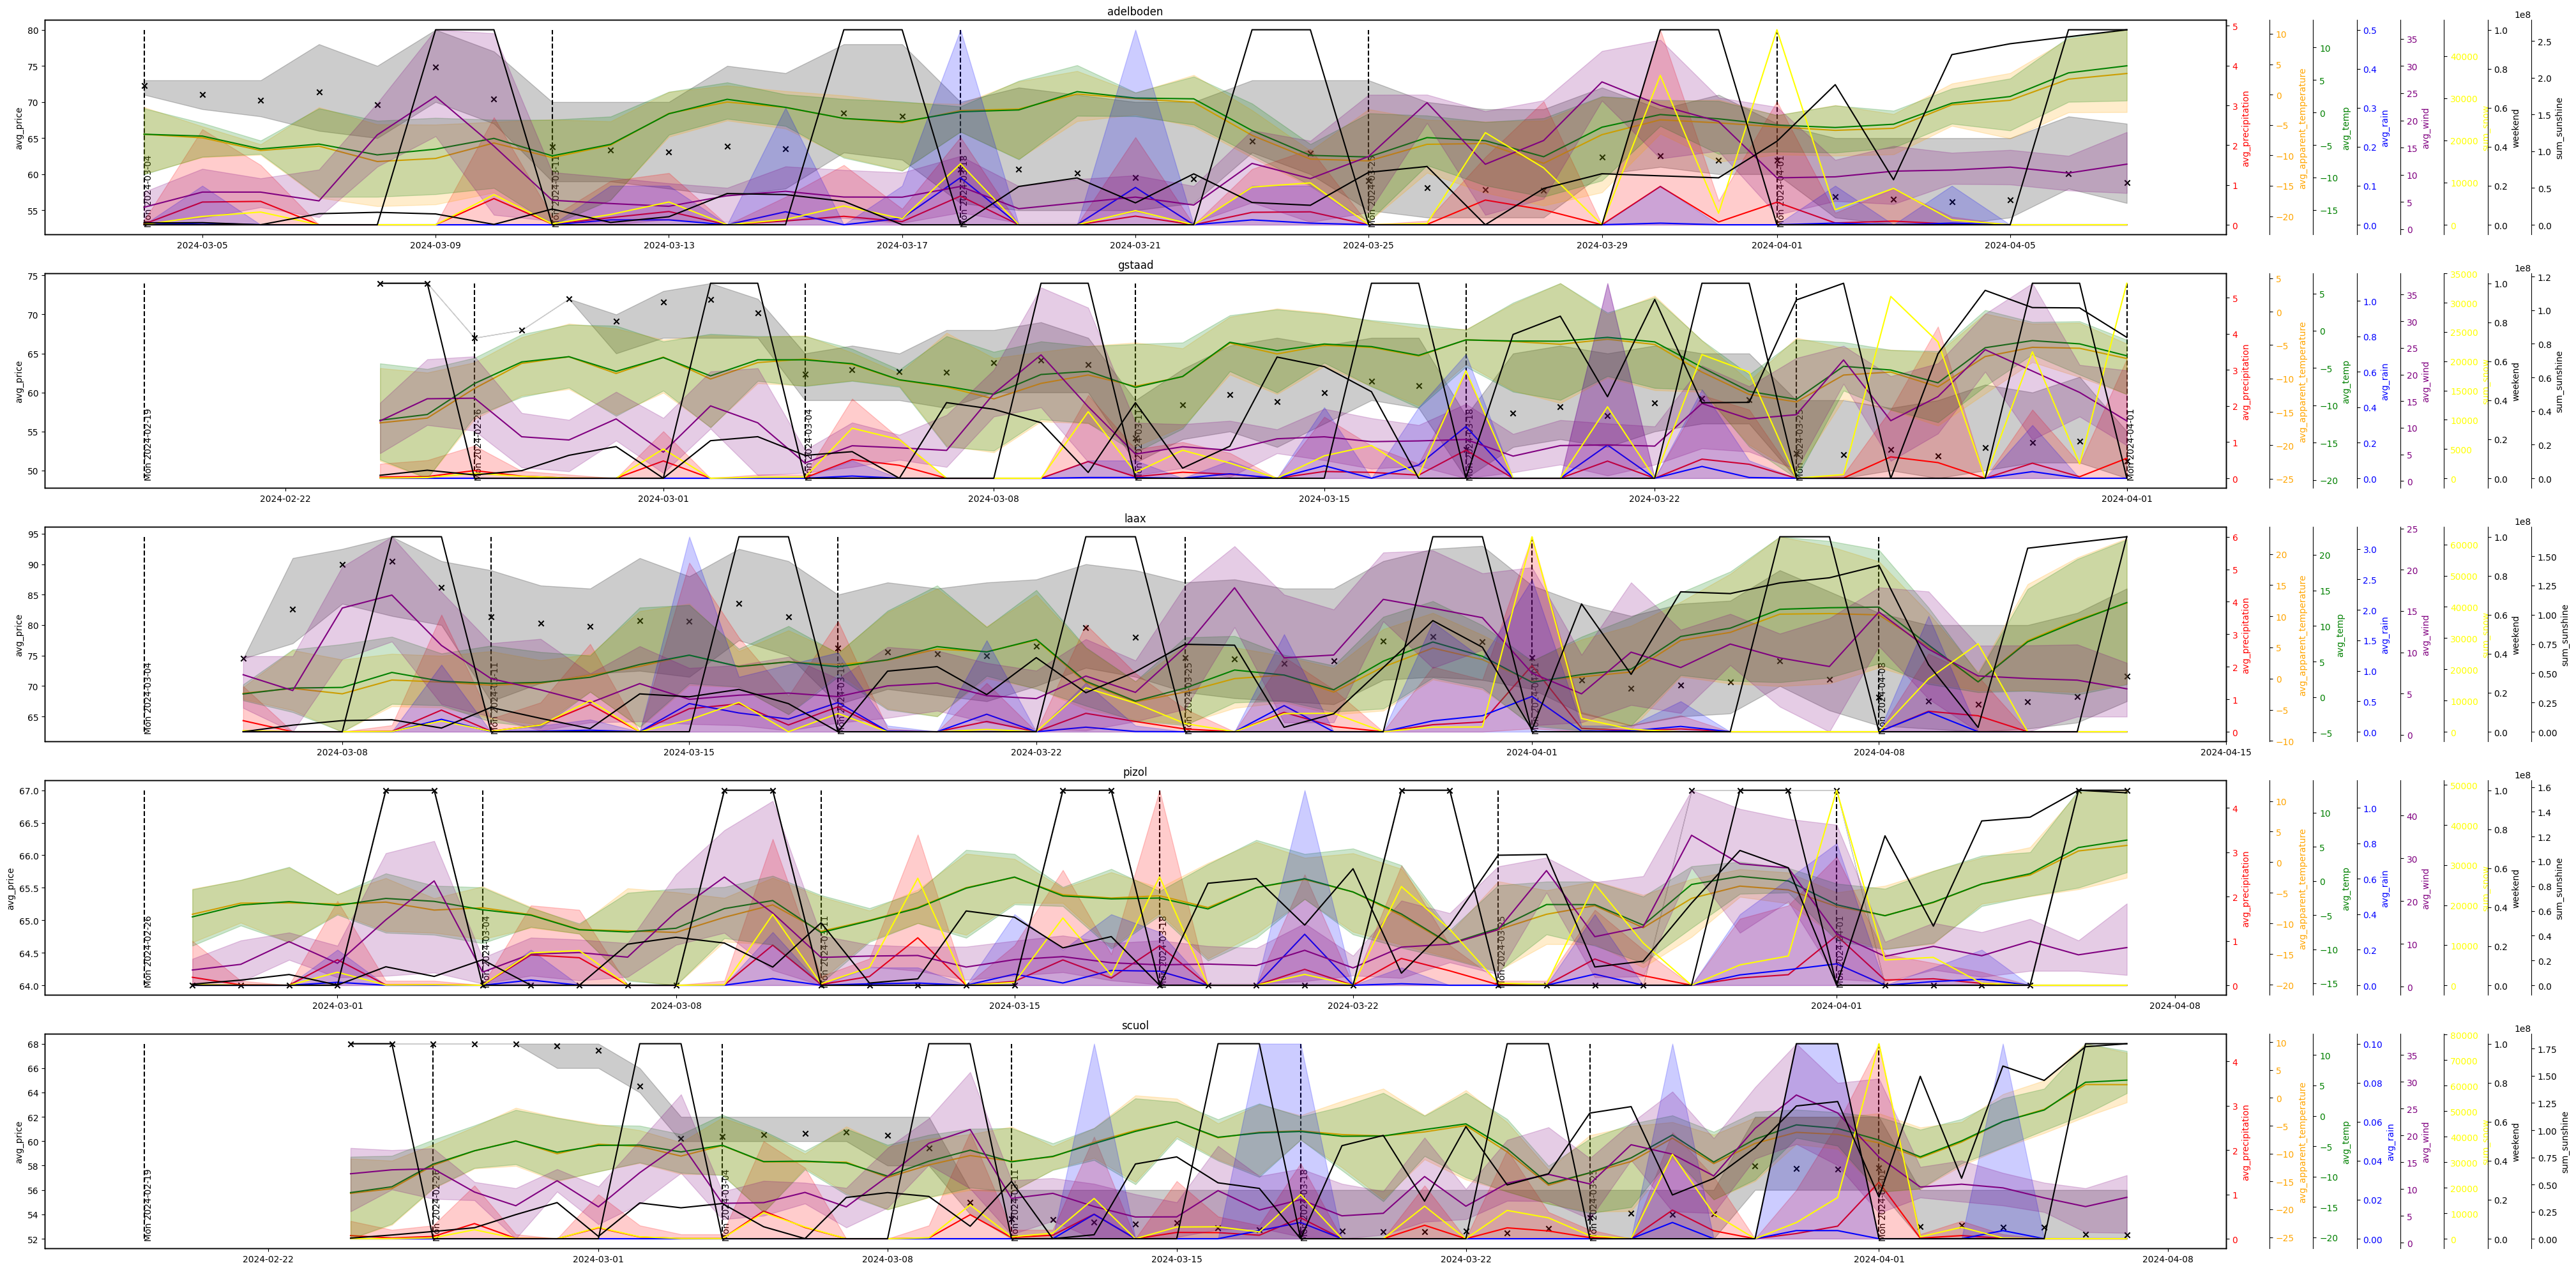

In [6]:
# Plot the data by resort
groups = data.groupby("resort")
fig = print_groups(
    groups, [
    ('avg_price', 'black', ["min_price", "max_price"]),
    ('avg_precipitation', 'red', ["max_precipitation", "min_precipitation"]),
    ('avg_apparent_temperature', 'orange', ["max_apparent_temperature", "min_apparent_temperature"]),
    ('avg_temp', 'green', ["max_temp", "min_temp"]),
    ('avg_rain', 'blue', ["max_rain", "min_rain"]),
    ('avg_wind', 'purple', ["max_wind", "min_wind"]),
    ('sum_snow', 'yellow', []),
    ('weekend', 'black', []),
    ('sum_sunshine', 'black', [])
])

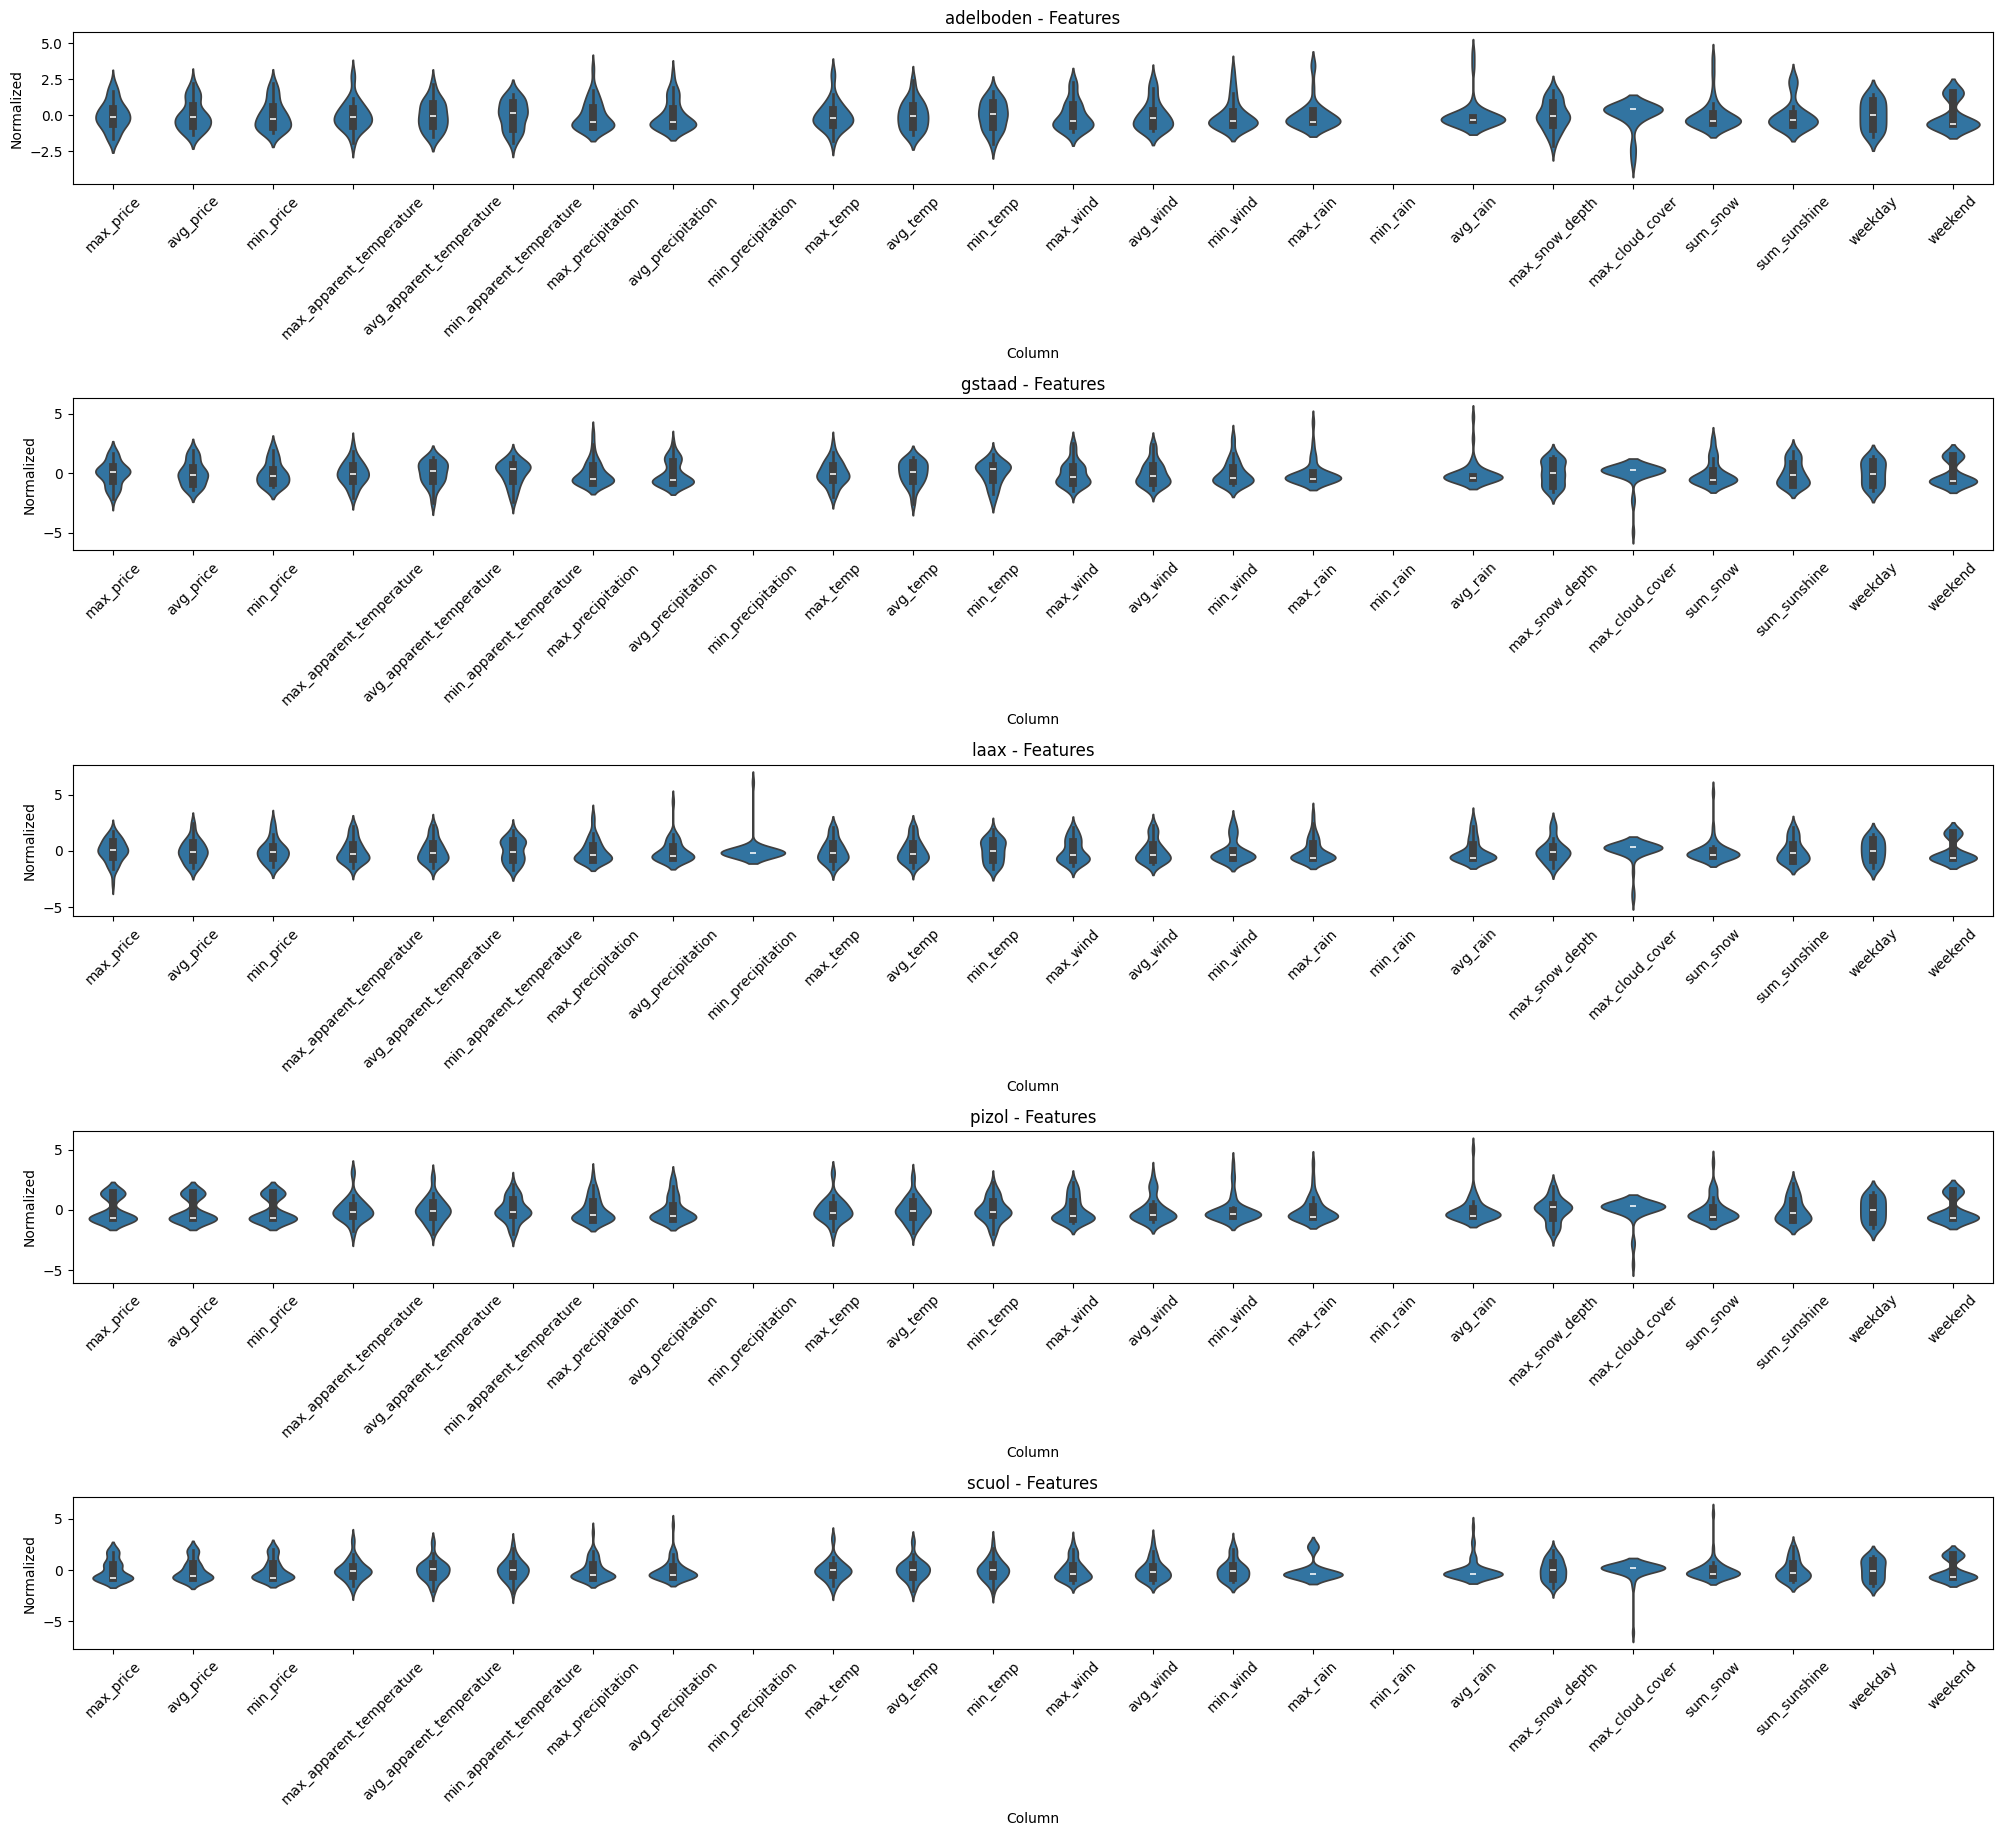

In [7]:
groups = data.groupby("resort")
fig = print_violins(groups, drop_cols=["date", "resort"])

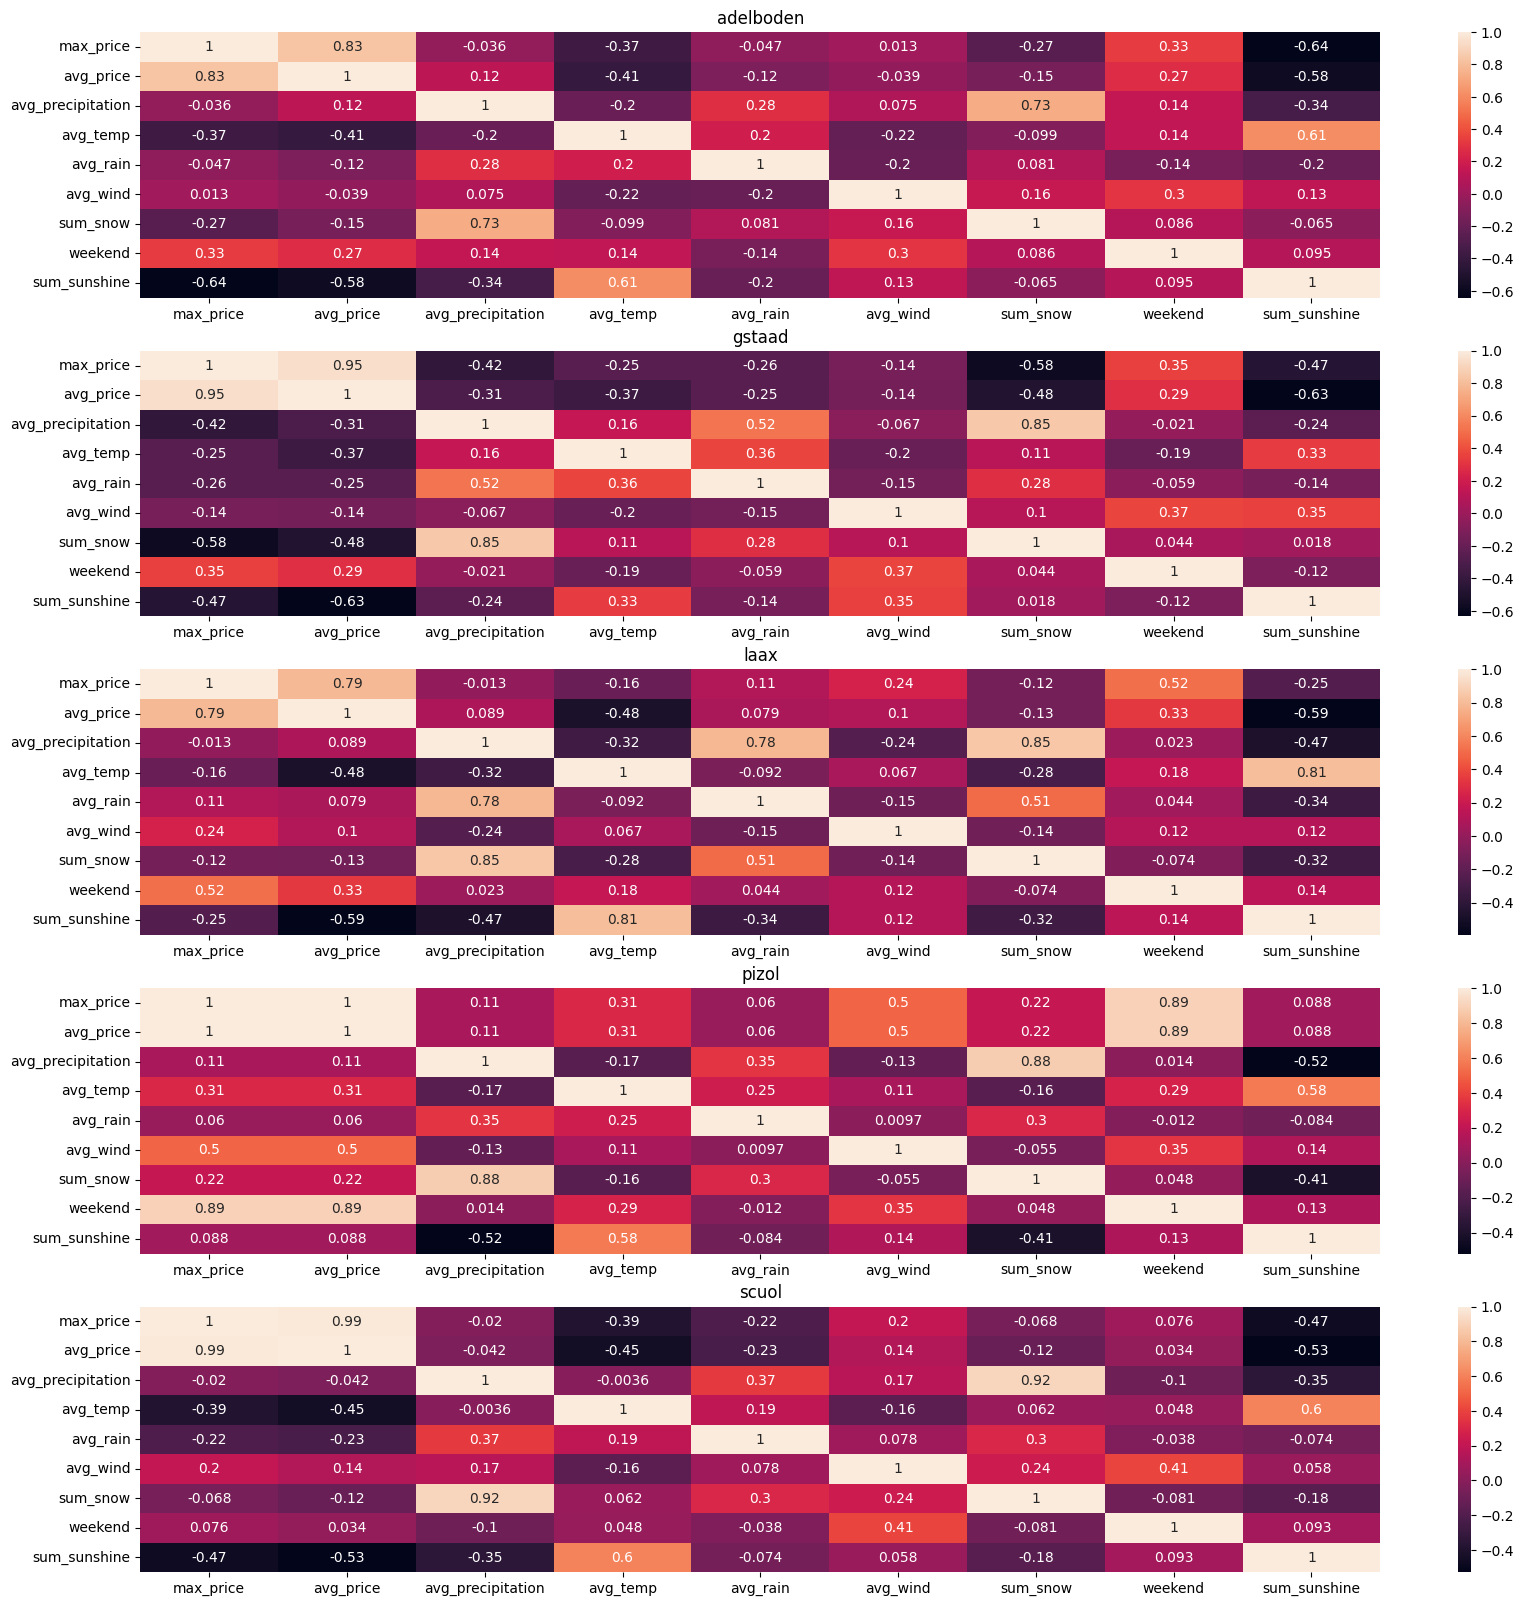

In [8]:
groups = data.groupby("resort")

tmp = []
for resort_name, df in groups:
    tmp.append((resort_name, df[["max_price", "avg_price", "avg_precipitation", "avg_temp", "avg_rain", "avg_wind", "sum_snow", "weekend", "sum_sunshine"]]))

fig = plt.figure(figsize=(20, 20))
for index, (resort_name, df) in enumerate(tmp):
    ax = fig.add_subplot(5,1,index+1, title=resort_name)
    sns.heatmap(df.corr(), annot=True, ax=ax)

/tmp/ipykernel_1690/1393302528.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


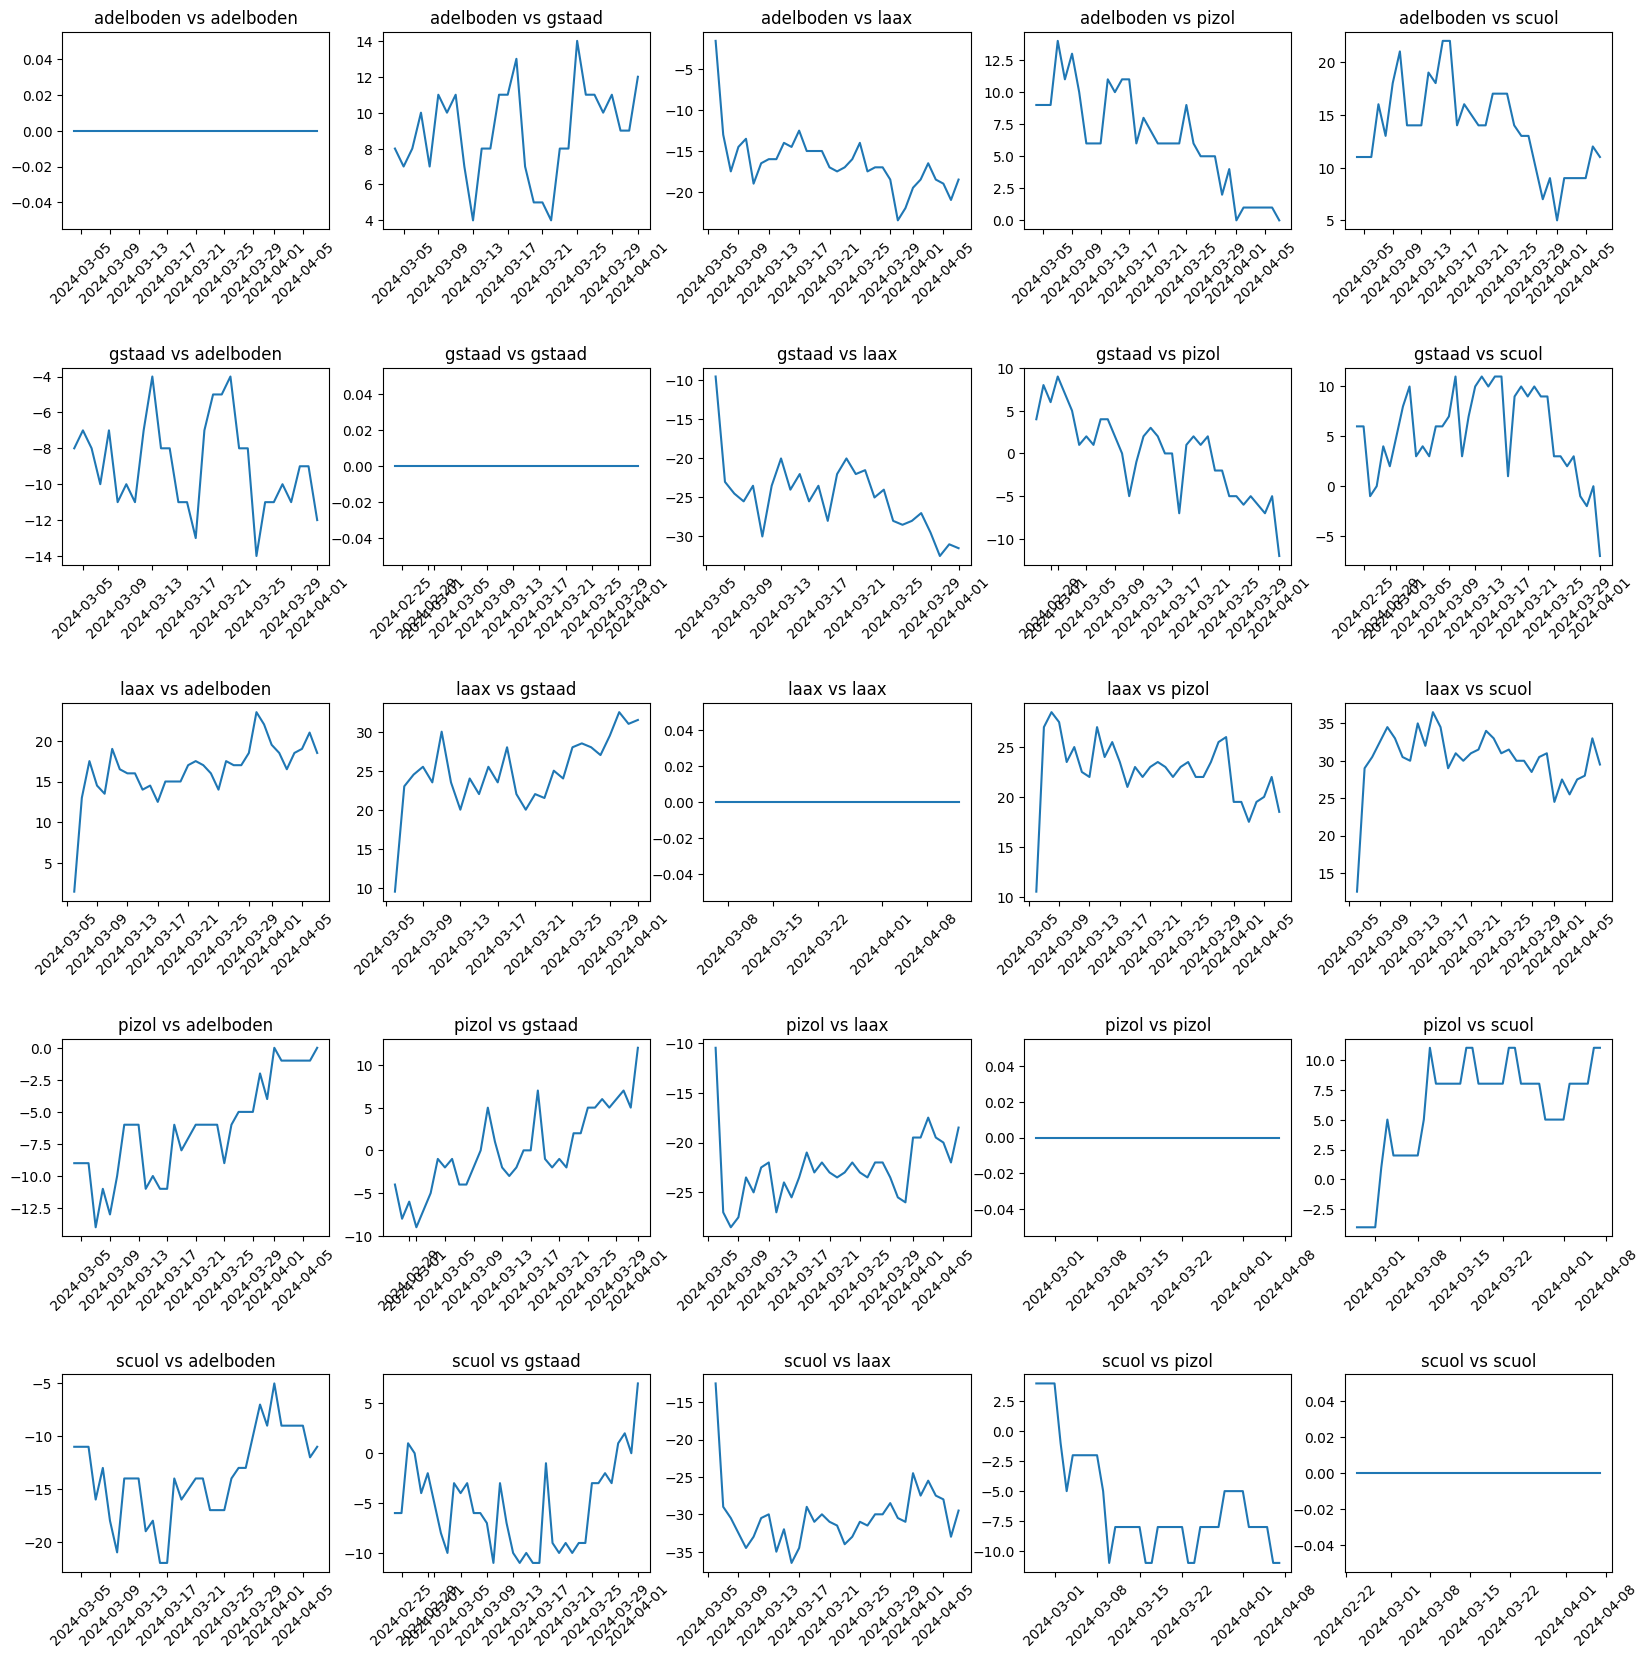

In [9]:
groups = data.groupby("resort")

tmp = []
for resort_name, df in groups:
    tmp.append((resort_name, df[["max_price"]]))

fig = plt.figure(figsize=(20, 20))
for index, (resort_name, df) in enumerate(tmp):
    for ind in range(len(tmp)):
        r1_name = tmp[index][0]
        r2_name = tmp[ind][0]
        ax = plt.subplot2grid((len(tmp), len(tmp)), (index,ind), title=f"{r1_name} vs {r2_name}")

        d1 = tmp[index][1]
        d2 = tmp[ind][1]

        d = d1 - d2
        ax.plot(d.index, d["max_price"])
        ax.tick_params(axis='x', labelrotation=45)
        
fig.subplots_adjust(hspace=0.7)
fig.show()

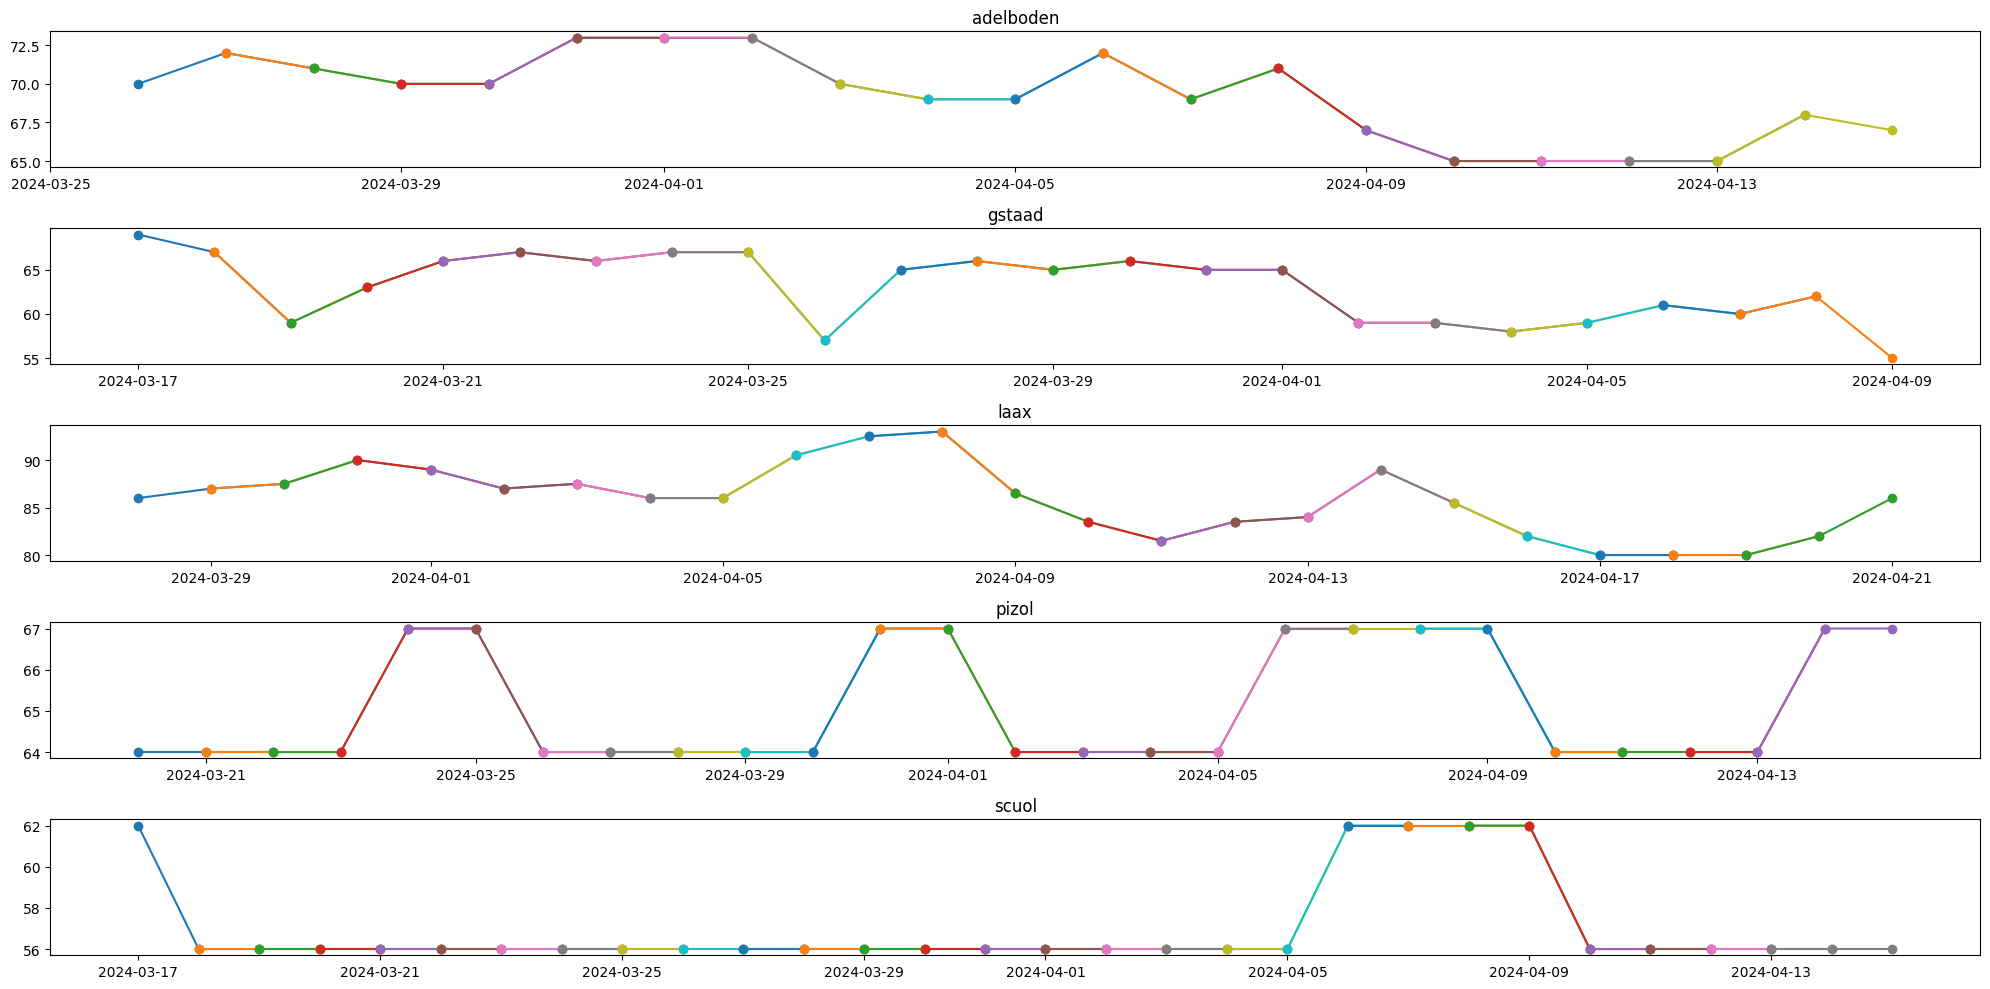

In [20]:
# Prepare the data
groups = data.groupby("resort")

# Define the features and targets
selected_freatures = data[["max_price", "avg_temp", "max_wind", "avg_wind", "max_precipitation", "avg_precipitation", "sum_snow", "weekend"]].columns
selected_targets = data[["max_price"]].columns

# Define the window size (14 days input and 3 days output)
X_WINDOW_SIZE = 14
Y_WINDOW_SIZE = 3

# Cunk the data
data_chunks = []
for group_index, (group_name, df) in enumerate(groups):
    # d_mean = df_raw["max_price"].mean()
    # d_std = df_raw["max_price"].std()
    # df = df_raw.copy()
    # df['max_price'] = (df_raw['max_price']-d_mean)/d_std

    df["price_surge"] = df["max_price"] - df["min_price"]
    for index in range(len(df.index) - (X_WINDOW_SIZE + Y_WINDOW_SIZE -1)):
        date = df.iloc[index].date
        feature_df = df[selected_freatures]
        target_df = df[selected_targets]
        X = np.array(
            feature_df.iloc[index:index+X_WINDOW_SIZE],
            dtype=np.float32
        )
        Y = np.array(
            target_df.iloc[index+X_WINDOW_SIZE-(X_WINDOW_SIZE-Y_WINDOW_SIZE):index+X_WINDOW_SIZE+Y_WINDOW_SIZE],
            dtype=np.float32
        )
        data_chunks.append((
            np.reshape(X, (X.shape[0], 1, X.shape[1])),
            np.reshape(Y, (Y.shape[0], 1, Y.shape[1])),
            date,
            group_name
        ))

fig = plt.figure(figsize=(20, 10))
# Verify the data actually looks like what we expect
for index, (group_name, group) in enumerate(itertools.groupby(data_chunks, key=lambda x: x[3])):
    axis = fig.add_subplot(
        5,1,index+1,
        title=group_name
    )
    X, Y, dates, _ = zip(*group)
    for gi, y in list(enumerate(Y)):
        base = X_WINDOW_SIZE - Y_WINDOW_SIZE
        labels = {}
        for idx, val in enumerate(y[base:]):
            date = datetime.datetime.strptime(dates[gi], "%Y-%m-%d") + datetime.timedelta(days=base + idx + (X_WINDOW_SIZE - Y_WINDOW_SIZE))
            labels[date] = val[0][0]
        axis.plot(labels.keys(), labels.values(), marker="o")

fig.tight_layout()

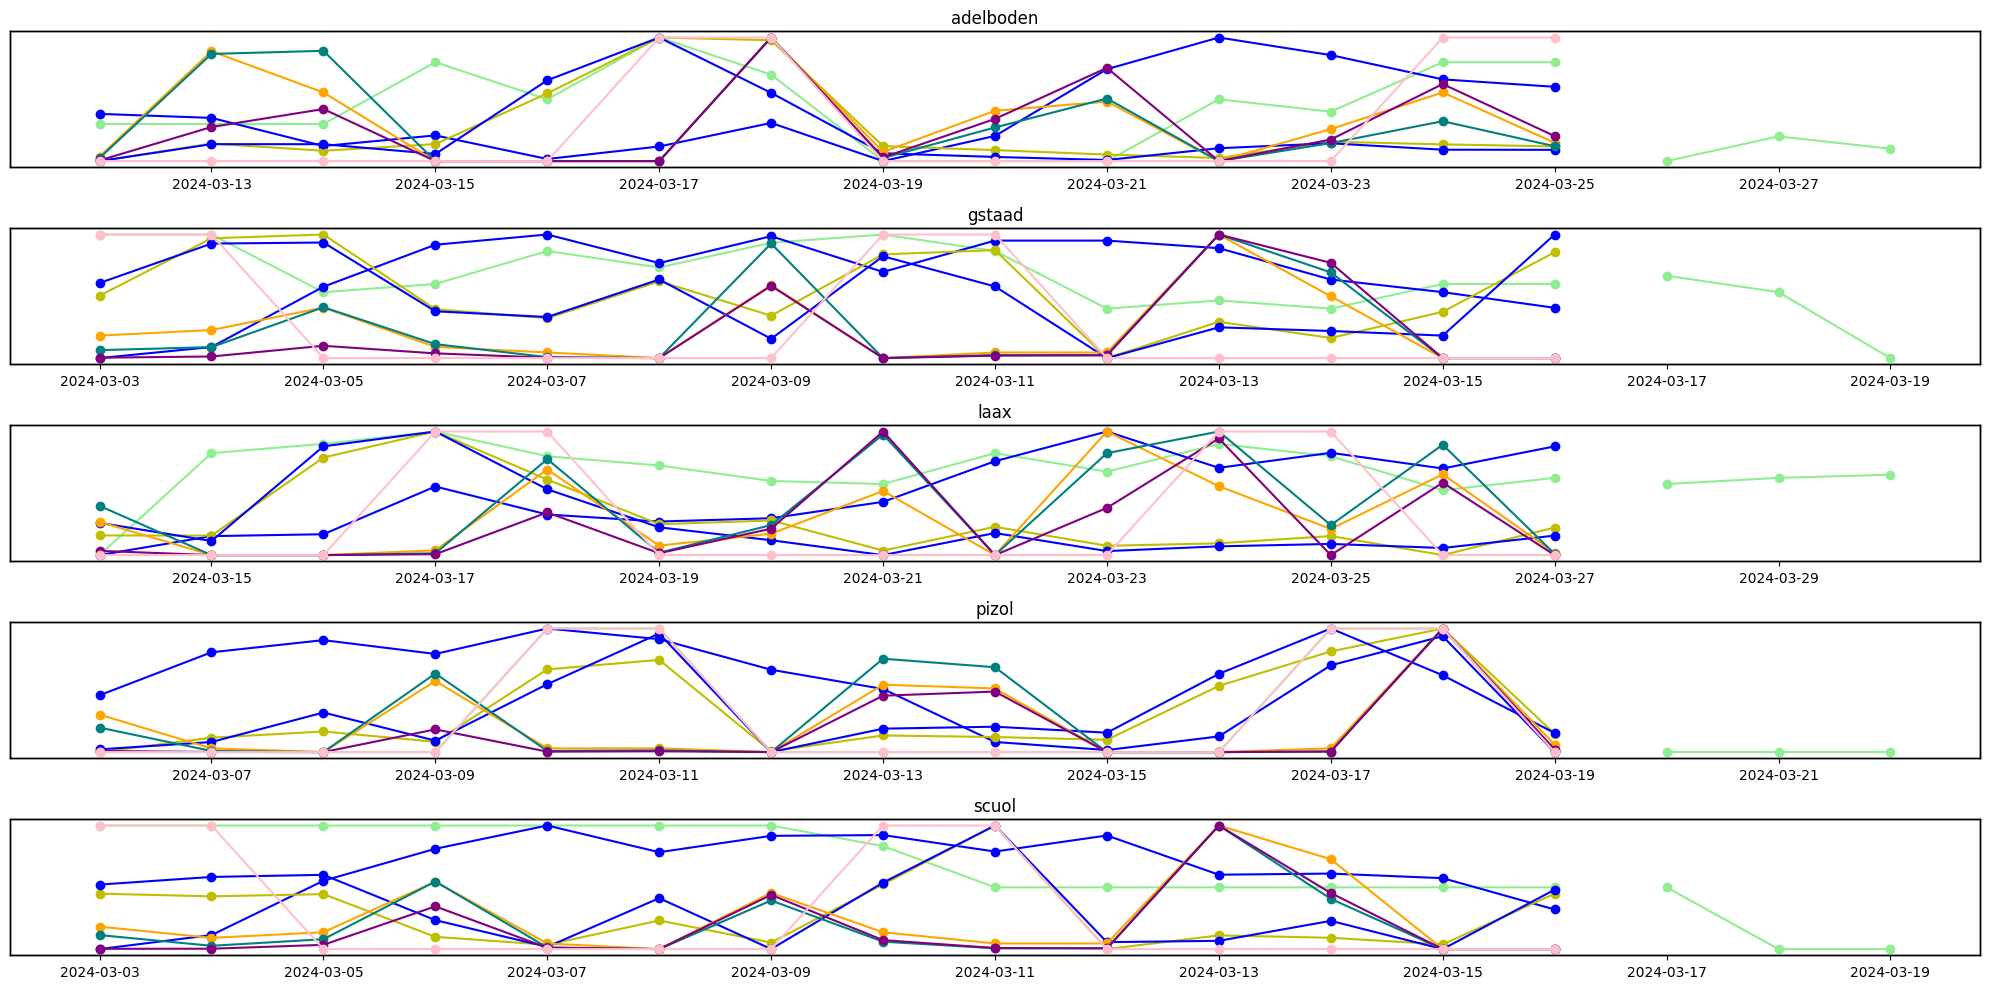

In [109]:
fig = plt.figure(figsize=(20, 10))
colors = ["lightgreen", "b", "y", "b", "orange", "teal", "purple", "pink"]
# Verify the data actually looks like what we expect
for index, (group_name, group) in enumerate(itertools.groupby(data_chunks, key=lambda x: x[3])):
    axis = fig.add_subplot(
        5,1,index+1,
        yticks=[],
        title=group_name
    )
    X, Y, dates, _ = zip(*group)
    for gi, y in list(enumerate(Y))[0:1]:
        base = X_WINDOW_SIZE - Y_WINDOW_SIZE
        labels = {}
        for idx, val in enumerate(y[base:]):
            date = datetime.datetime.strptime(dates[gi], "%Y-%m-%d") + datetime.timedelta(days=base + idx + (X_WINDOW_SIZE - Y_WINDOW_SIZE))
            labels[date] = val[0][0]
        axis.plot(labels.keys(), labels.values(), marker="o", color="lightgreen")

    for gi, y in list(enumerate(X))[0:1]:
        base = X_WINDOW_SIZE
        labels = {}
        for i, feature in enumerate(selected_freatures):
            for idx, val in enumerate(y[:base]):
                date = datetime.datetime.strptime(dates[gi], "%Y-%m-%d") + datetime.timedelta(days=base + idx - Y_WINDOW_SIZE - 3)
                labels[date] = val[0][i]
            ax = axis.twinx() if i > 0 else axis
            ax.plot(labels.keys(), labels.values(), label=feature, color=colors[i], marker="o")
            ax.set_yticks([])

fig.tight_layout()

In [23]:
def get_model(metrics, lr=0.01):
    # Define the model architecture
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_WINDOW_SIZE, len(selected_freatures))))
    model.add(keras.layers.Conv1D(
        filters=128,
        kernel_size=3,
        strides=7,
        padding="causal"
    ))
    model.add(keras.layers.LSTM(64, return_sequences=False))
    model.add(keras.layers.LeakyReLU(negative_slope=0.3))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.LeakyReLU(negative_slope=0.3))
    model.add(keras.layers.Dense(Y_WINDOW_SIZE * len(selected_freatures)))
    model.add(keras.layers.Reshape(target_shape=(Y_WINDOW_SIZE, len(selected_freatures))))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.MeanSquaredError(),
        metrics=metrics
    )

    return model


def split_data(shuffled_data, train_size=0.8):
    train_val_split = int(len(shuffled_data) * train_size)
    X_train, Y_train, dates_train, _ = zip(*shuffled_data[:train_val_split])
    X_val, Y_val, dates_val, _ = zip(*shuffled_data[train_val_split:])

    return X_train, Y_train, dates_train, X_val, Y_val, dates_val

def fit_model(model, X_train, Y_train, X_val, Y_val, epochs=100, logdir="logs", patience=20):
    # Fit the model
    return model.fit(
        X_train, Y_train, 
        batch_size=len(X_train)//3,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=patience),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0000001, patience=3, mode='min'),
            keras.callbacks.TerminateOnNaN(),
            keras.callbacks.TensorBoard(log_dir=logdir),
        ]
    )

In [28]:
MAX_EPOCS = 1000
METRIC = "mean_squared_error"

# Keep track of the best model
hist = {}

# Shuffle the data and split it into folds
shuffled_data = data_chunks.copy()
random.shuffle(shuffled_data)

resorts = set([a[3] for a in data_chunks])
NUMBER_FOLDS = len(resorts)
print(f"Using total of {len(shuffled_data)} data points in {NUMBER_FOLDS} folds")

for fold_no, resort_name in enumerate(resorts):
    # length = len(shuffled_data)
    # size = length // (NUMBER_FOLDS)
    # start_index = fold_no * size #length // 2 - length // 10
    # end_index = start_index + size #length // 2 + length // 10

    in_fold_data = [d for d in shuffled_data if d[3] != resort_name] #[:start_index] + shuffled_data[end_index:]
    out_fold_data = [d for d in shuffled_data if d[3] == resort_name] #shuffled_data[start_index:end_index]

    # Split the data into training and validation
    X_train, Y_train, dates_train, X_val, Y_val, dates_val = split_data(in_fold_data, train_size=0.8)
    print(f"Fold {fold_no} has {len(in_fold_data)} data points with {len(X_train)} training and {len(X_val)} validation data points and {len(out_fold_data)} test data points. (excluded resort: {resort_name})")

    # Define the model architecture
    model = get_model(metrics=[METRIC, "mean_absolute_error", tf.keras.metrics.LogCoshError()], lr=0.0001)

    # Fit the model
    history = fit_model(model, X_train, Y_train, X_val, Y_val, epochs=MAX_EPOCS, logdir=f"logs-{fold_no}", patience=100)

    # Evaluate the model
    X_test, Y_test, dates_test, _ = zip(*out_fold_data)
    scores = model.evaluate(X_test, Y_test, verbose=2, return_dict=True)

    # Save the model
    model.save(f'fold-{fold_no}.keras')
    hist[fold_no] = {
        "history": history,
        "scores": scores,
        "model": model
    }


Using total of 117 data points in 5 folds
Fold 0 has 98 data points with 78 training and 20 validation data points and 19 test data points. (excluded resort: adelboden)
1/1 - 0s - 311ms/step - logcosh: 10.2298 - loss: 152.5936 - mean_absolute_error: 10.8973 - mean_squared_error: 152.5936
Fold 1 has 89 data points with 71 training and 18 validation data points and 28 test data points. (excluded resort: scuol)
1/1 - 0s - 194ms/step - logcosh: 3.2951 - loss: 24.3481 - mean_absolute_error: 3.9396 - mean_squared_error: 24.3481
Fold 2 has 94 data points with 75 training and 19 validation data points and 23 test data points. (excluded resort: laax)
1/1 - 0s - 208ms/step - logcosh: 24.1046 - loss: 626.2097 - mean_absolute_error: 24.7977 - mean_squared_error: 626.2097
Fold 3 has 95 data points with 76 training and 19 validation data points and 22 test data points. (excluded resort: gstaad)
1/1 - 0s - 300ms/step - logcosh: 3.0142 - loss: 19.9557 - mean_absolute_error: 3.6378 - mean_squared_error

/tmp/ipykernel_1690/2177329639.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


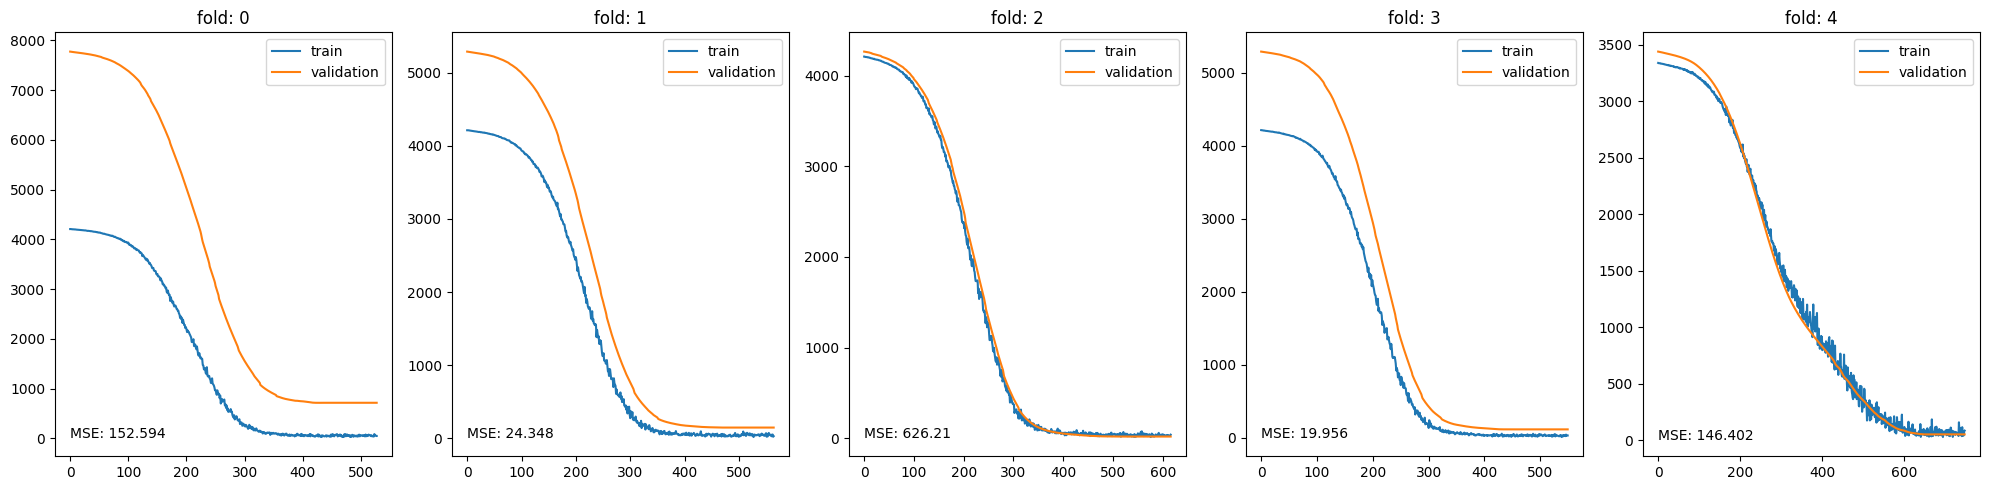

In [34]:
fig = plt.figure(figsize=(20, 5))
for index in hist:
    history = hist[index].get("history")
    axis = fig.add_subplot(
        1,len(hist),index+1,
        title=f"fold: {index}"
    )
    axis.text(0.5, 0.5, f"MSE: {round(hist[index].get('scores').get(METRIC),3)}")
    axis.plot(history.history[METRIC], label="train")
    axis.plot(history.history["val_" + METRIC], label="validation")
    axis.legend()

fig.tight_layout()
fig.show()

In [40]:
for index in hist:
    scores = hist[index].get("scores")
    print("-----")
    print(f"Fold {index}")
    print(f"LogCosh: {scores["logcosh"]}")
    print(f"MAE: {scores["mean_absolute_error"]}")
    print(f"MSE: {scores["mean_squared_error"]}")
print("-----")    

-----
Fold 0
LogCosh: 10.229758262634277
MAE: 10.897336959838867
MSE: 152.59361267089844
-----
Fold 1
LogCosh: 3.295149564743042
MAE: 3.9396018981933594
MSE: 24.348140716552734
-----
Fold 2
LogCosh: 24.104572296142578
MAE: 24.797719955444336
MSE: 626.2096557617188
-----
Fold 3
LogCosh: 3.0142014026641846
MAE: 3.637774705886841
MSE: 19.9556827545166
-----
Fold 4
LogCosh: 10.516326904296875
MAE: 11.202733993530273
MSE: 146.40237426757812
-----


-----
fold: 0
mean data: 69.35 - mean predictions: 61.13
max data: 94.50 - max predictions: 67.63
min data: 55.00 - min predictions: 56.58
-----
fold: 1
mean data: 69.35 - mean predictions: 60.64
max data: 94.50 - max predictions: 67.63
min data: 55.00 - min predictions: 55.78
-----
fold: 2
mean data: 69.35 - mean predictions: 62.01
max data: 94.50 - max predictions: 68.08
min data: 55.00 - min predictions: 55.78
-----
fold: 3
mean data: 69.35 - mean predictions: 62.60
max data: 94.50 - max predictions: 68.08
min data: 55.00 - min predictions: 55.78
-----
fold: 4
mean data: 69.35 - mean predictions: 60.44
max data: 94.50 - max predictions: 68.08
min data: 55.00 - min predictions: 33.60
-----


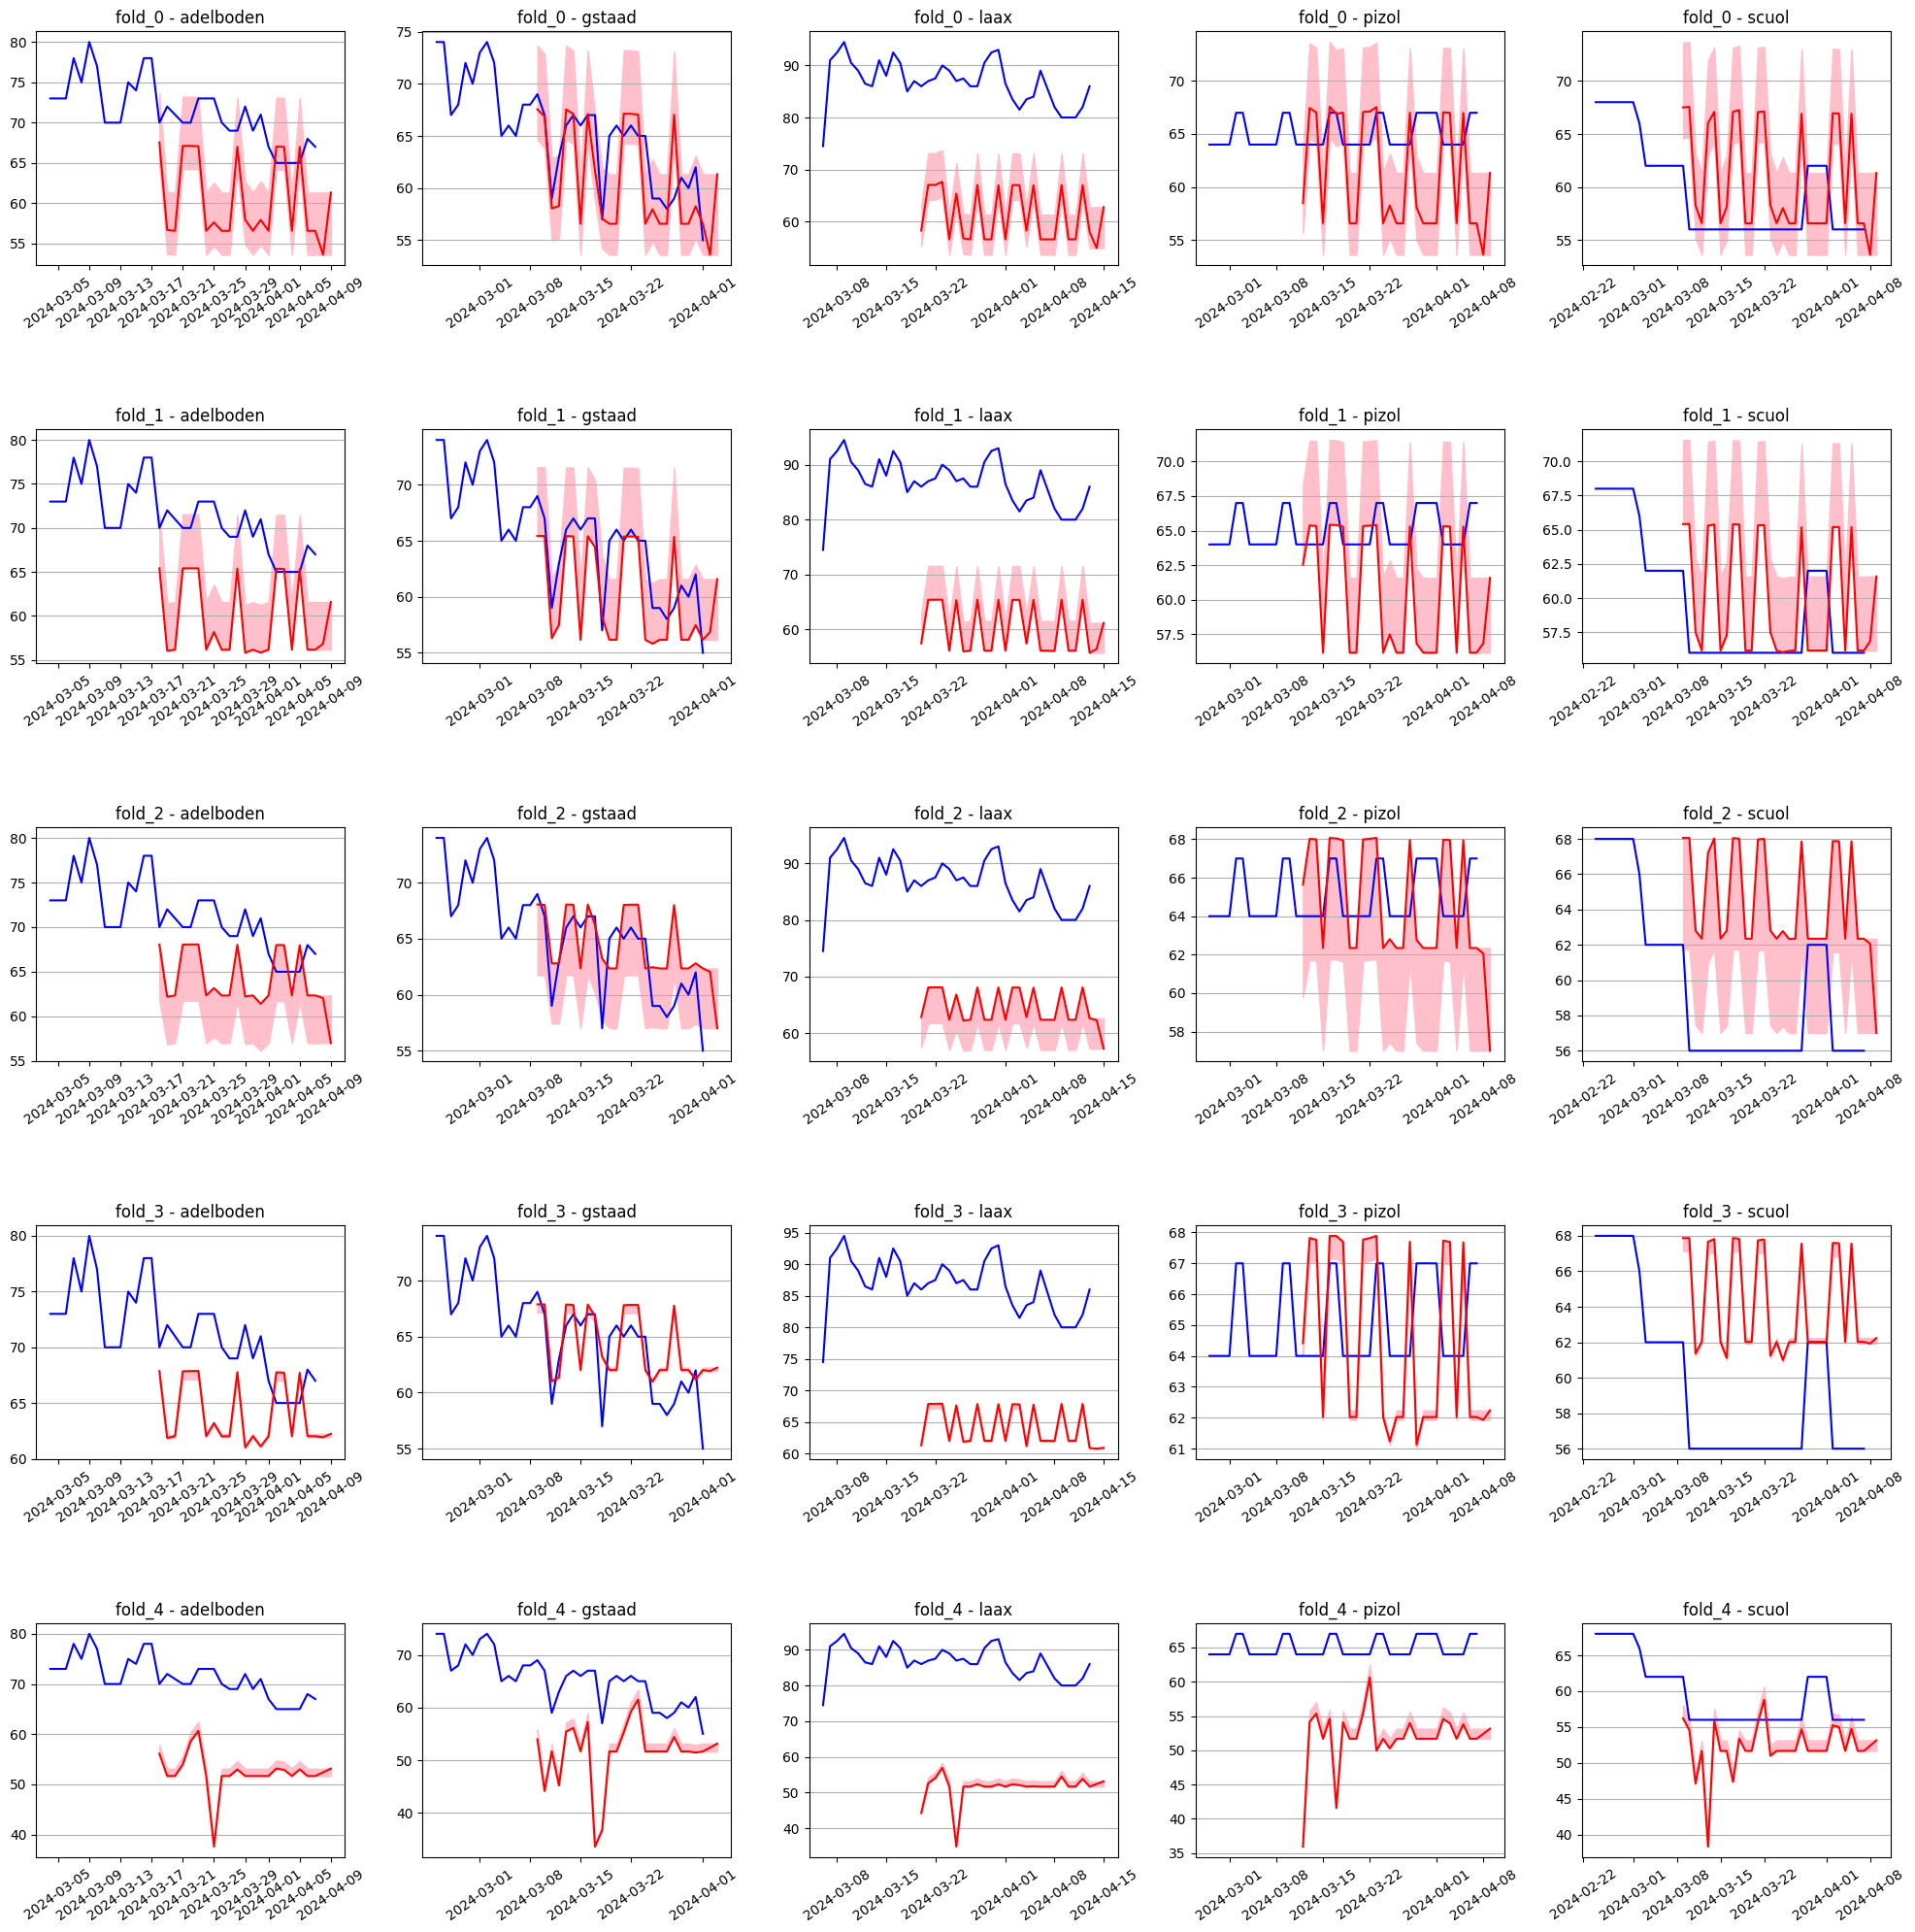

In [56]:
predictions = []
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    model = keras.models.load_model(f'fold-{i}.keras')
    for group_index, (group_name, df) in list(enumerate(groups)):
        pp = {}
        rr = len(df.index) - (X_WINDOW_SIZE)
        for index in range(rr):
            date = datetime.datetime.strptime(df.iloc[index].date, "%Y-%m-%d")
            feature_df = df[selected_freatures]
            target_df = df[selected_targets]
            # for selected_target in selected_targets:
            #     d_mean = df[selected_target].mean()
            #     d_std = df[selected_target].std()
            #     target_df[selected_target] = (df[selected_target]-d_mean)/d_std
            
            X = np.array(
                feature_df.iloc[index:index+X_WINDOW_SIZE],
                dtype=np.float32
            )
            model_preds = model(np.reshape(X, (X.shape[0], 1, X.shape[1])))
            preds = [p.numpy()[-1] for p in model_preds[0]]
            predictions.append(preds[0])
            #preds = [p * d_std + d_mean for p in preds]
            p_date = date + datetime.timedelta(days=X_WINDOW_SIZE)
            if p_date not in pp:
                pp[p_date] = {"0": preds[0], "max": preds[0], "min": preds[0]}

            pred_max = max(preds[0:3])
            pred_min = min(preds[0:3])

            if pred_max > pp[p_date]["max"]:
                pp[p_date]["max"] = pred_max

            if pred_min < pp[p_date]["min"]:
                pp[p_date]["min"] = pred_min

            if index == rr - 1:
                pp[p_date + datetime.timedelta(days=1)] = {"0": preds[1], "max": pred_max, "min": pred_min}
                pp[p_date + datetime.timedelta(days=2)] = {"0": preds[2], "max": pred_max, "min": pred_min}

        d = pd.DataFrame.from_dict(pp, orient='index')

        # axis = fig.add_subplot(
        #     5**2,1,i+group_index+1,
        #     yticks=[55,70,85,100],
        #     title=f"fold_{i} - {group_name}"
        # )
        axis = plt.subplot2grid((5,5), (i,group_index), title=f"fold_{i} - {group_name}")
        axis.grid(axis="y")
        axis.plot(df.index, df["max_price"], color="blue", label="price")
        axis.plot(d.index, d["0"], color="red", label="1 day prediction")
        axis.fill_between(d.index, d["min"], d["max"], color="pink", label="3 day prediction")
        axis.tick_params(axis='x', labelrotation=35)

    print("-----") 
    print(f"fold: {i}")
    print(f"mean data: {data["max_price"].mean():,.2f} - mean predictions: {sum(predictions)/len(predictions):,.2f}")
    print(f"max data: {data["max_price"].max():,.2f} - max predictions: {max(predictions):,.2f}")
    print(f"min data: {data["max_price"].min():,.2f} - min predictions: {min(predictions):,.2f}")

print("-----") 

fig.tight_layout()
fig.subplots_adjust(hspace=0.7)
fig.show()

In [110]:
model = keras.models.load_model(f'fold-0.keras')
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 2, 128)         │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 3, 8)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,610 (943.79 KB)

 Trainable params: 80,536 (314.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,074 (629.20 KB)

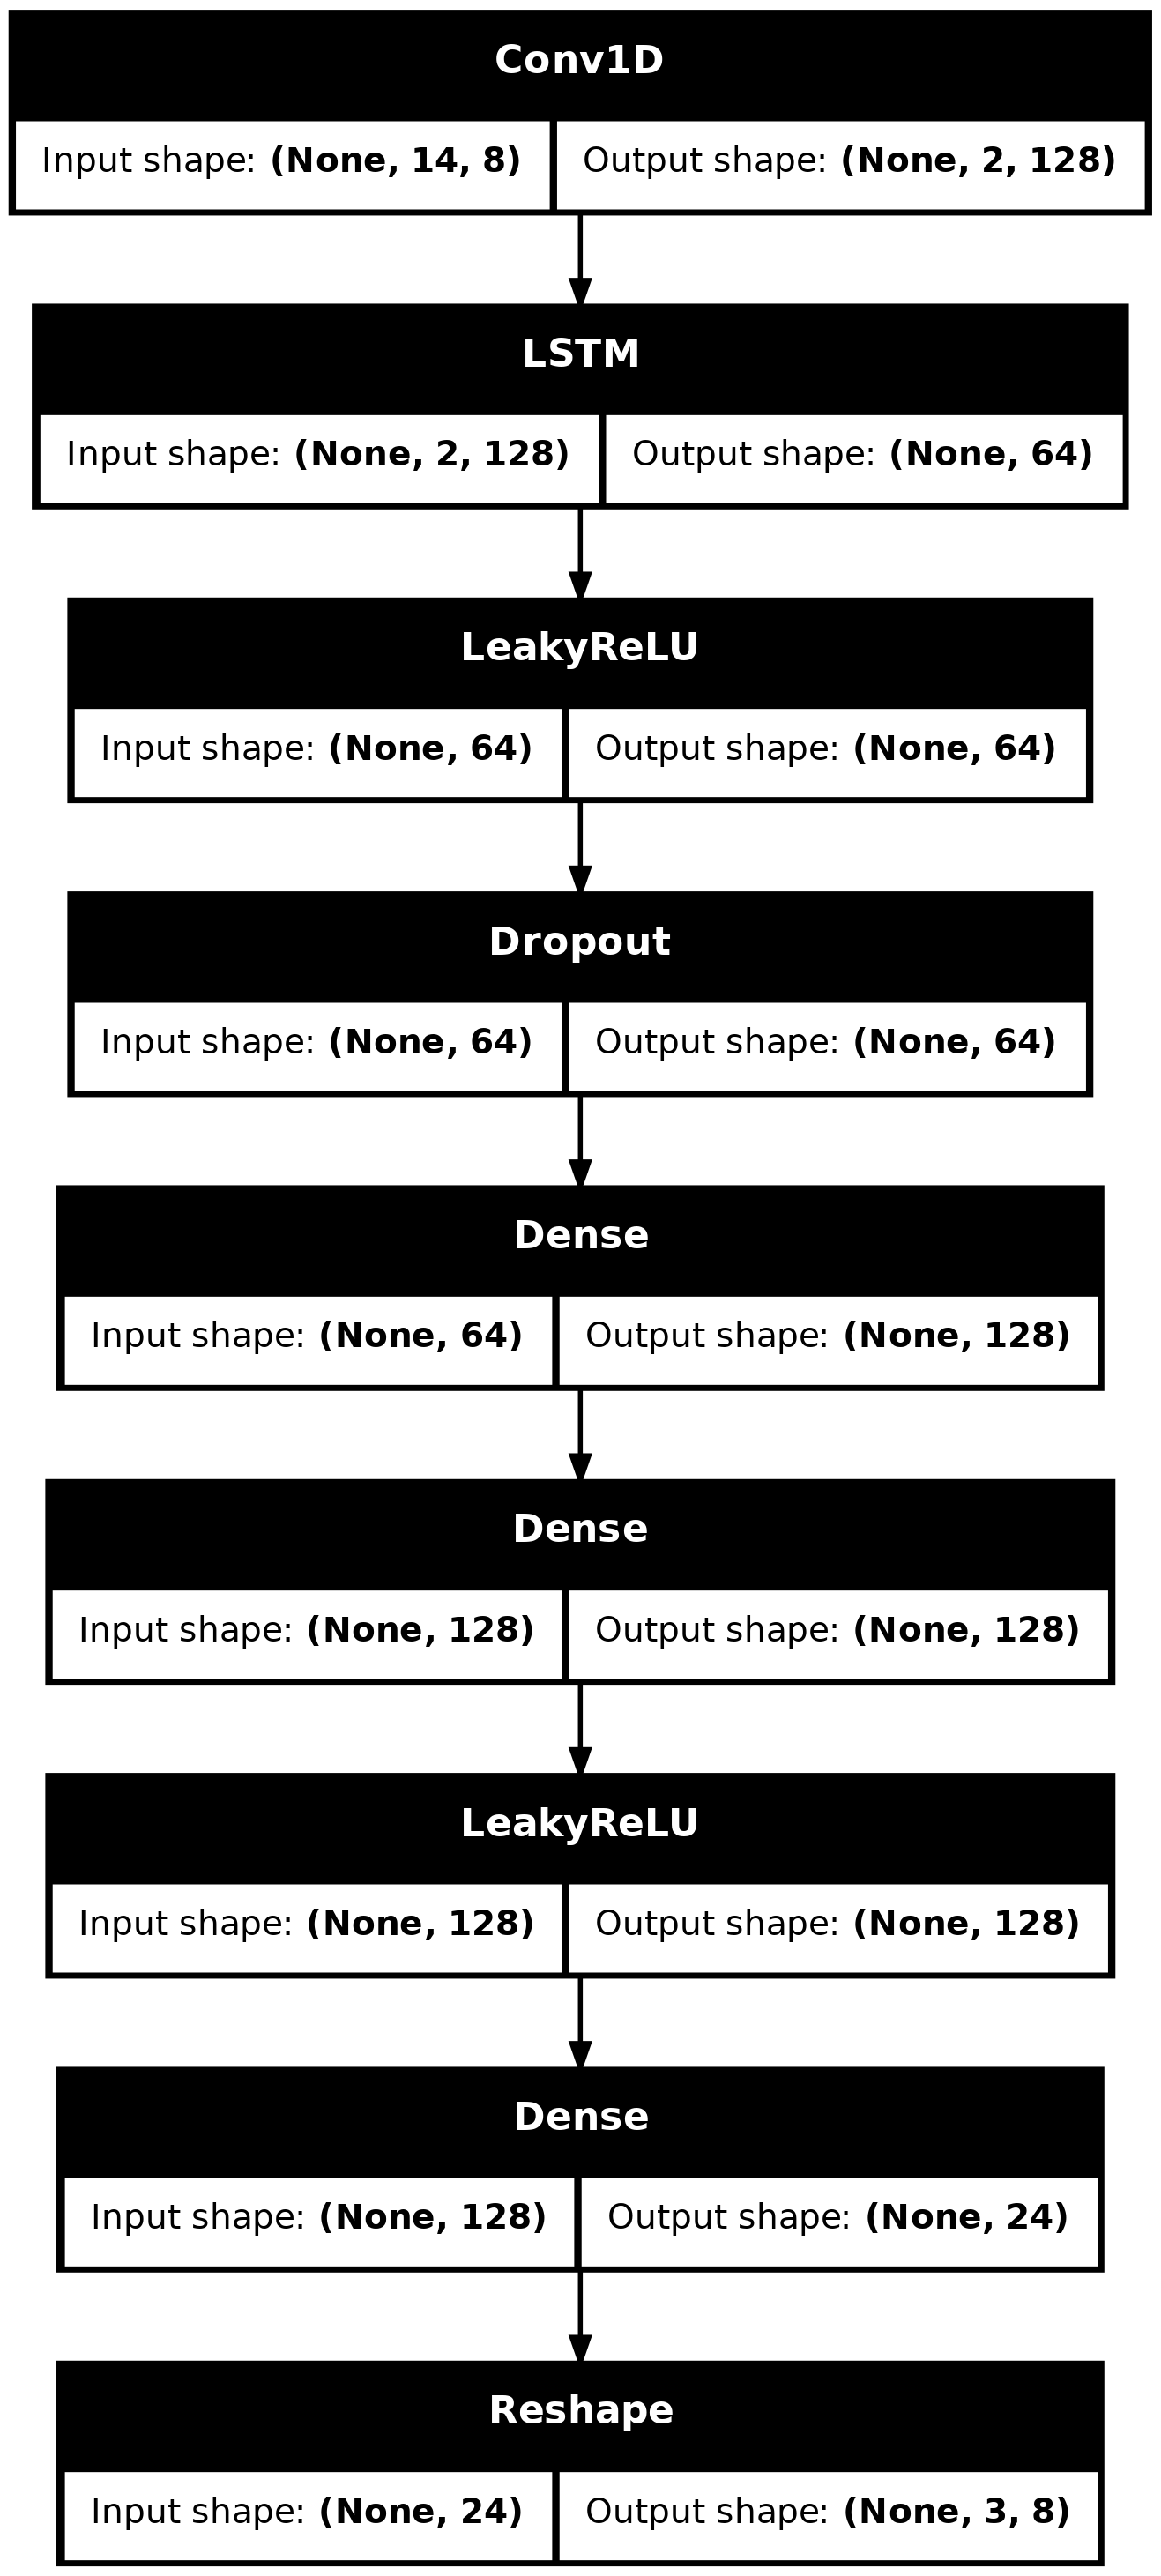

In [5]:
model = keras.models.load_model(f'fold-0.keras')
dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
import os
import platform
from platform import python_version

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-28-generic
Datetime: 2024-05-10 13:51:45
Python Version: 3.12.3
-----------------------------------
